In [1]:
import pandas as pd
from backend.src.utils.logging_handler import setup_logging
from backend.src.utils.config import Config

config = Config("../config.yaml")
setup_logging()

feature_engineering_config = config.get("feature_engineering")
preprocessor_config = config.get("preprocess")
model_config = config.get("model")

target_feature = preprocessor_config.get("target")
trend_length = preprocessor_config.get("trend_length")
window_size = preprocessor_config.get("window_size")
epochs: int = model_config.get("epochs")
batch_size: int = model_config.get("batch_size")

interval: str = feature_engineering_config.get("time_series_interval")

test_file_path: str = f"../data/twelvedata/time series ({interval})/AMZN/AMZN_time_series.csv"

test_df: pd.DataFrame = pd.read_csv(test_file_path)

In [2]:
from keras.models import load_model
from backend.src.evaluation.model_evaluator import ModelEvaluator
from backend.src.pipelines.stock_trend_lstm_test_pipeline import StockTrendLSTMTestPipeline

model_path: str = "../src/models/saved models/trained_StockTrendLSTM_model.keras"
model = load_model(model_path)

scaler_path: str = "../src/scaling/saved scalers/scaler.save"

test_pipeline = StockTrendLSTMTestPipeline(
    testing_time_series=test_df,
    target_feature=target_feature,
    trend_length=trend_length,
    window_size=window_size,
    scaler_path=scaler_path,
)
test_pipeline.prepare_data()
X_test, y_test = test_pipeline.get_test_data()

y_val_proba = model.predict(X_test).ravel()

evaluator = ModelEvaluator(
    y_true=y_test,
    y_proba=y_val_proba,
)

2026-01-05 16:37:28,065 | WARNING | tensorflow | From C:\Users\mohae\PycharmProjects\PythonProject\.venv\lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.

2026-01-05 16:37:32,999 | WARNING | tensorflow | From C:\Users\mohae\PycharmProjects\PythonProject\.venv\lib\site-packages\keras\src\backend.py:1398: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.

2026-01-05 16:37:33,671 | INFO | backend.src.pipelines.stock_trend_lstm_test_pipeline | StockTrendLSTMTestPipeline initialized
2026-01-05 16:37:33,671 | INFO | backend.src.pipelines.stock_trend_lstm_test_pipeline | Starting data preparation
2026-01-05 16:37:33,689 | INFO | backend.src.preprocessing.time_series_preprocessor | Preprocessing summary | input rows: 5000 | output rows: 5000 | dropped: 0 (100.00% retained)
2026-01-05 16:3

153/153 [==============================] - 2s 7ms/step


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
test_pipeline.labeled_testing_ts.head(10)

,open,high,low,close,volume,ADX,ATR,%Bollinger,EMA,MACD,RSI,sma,EMA dist. (%),EMA distance change,EMA dist. norm. (ATR),EMA slope (%),EMA acc.,EMA distance std.,log return(1),log return(2),log return(3),log return(9),oc log return,gap log return,close > EMA,EMA slope pos.,log return pos.,ATR stretch,bb% > 1,bb% < 0,day_of_week,hour_of_day,label
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-03-01 15:30:00,91.92,92.32,91.84,92.20,6726784,26.18,0.83,0.17,92.56,-0.60,39.79,92.71,-0.0039,0.0040,-0.4337,-0.0010,0.10,0.0066,0.003041,0.005765,-0.000108,-0.024957,0.003041,0.000000,0,0,1,0,0,0,2,15,1
2023-03-02 09:30:00,91.41,91.84,91.01,91.56,10055299,27.63,0.85,0.05,92.36,-0.65,35.84,92.44,-0.0087,-0.0048,-0.9412,-0.0022,-0.11,0.0067,-0.006966,-0.003924,-0.001201,-0.025981,0.001640,-0.008605,0,0,0,0,0,0,3,9,1
2023-03-02 10:30:00,91.57,91.59,90.76,90.78,7253405,29.17,0.85,-0.05,92.05,-0.75,31.71,92.06,-0.0138,-0.0051,-1.4941,-0.0034,-0.11,0.0071,-0.008555,-0.015521,-0.012480,-0.037193,-0.008665,0.000109,0,0,0,1,0,1,3,10,1
2023-03-02 11:30:00,90.78,90.86,90.39,90.60,6918780,30.85,0.83,0.00,91.76,-0.83,30.83,91.80,-0.0126,0.0012,-1.3976,-0.0032,0.02,0.0072,-0.001985,-0.010540,-0.017506,-0.025500,-0.001985,0.000000,0,0,0,1,0,0,3,11,1
2023-03-02 12:30:00,90.59,91.00,90.53,90.86,4143251,32.11,0.80,0.11,91.58,-0.86,33.70,91.62,-0.0079,0.0047,-0.9000,-0.0020,0.11,0.0062,0.002866,0.000881,-0.007675,-0.016807,0.002976,-0.000110,0,0,1,0,0,0,3,12,1
2023-03-02 13:30:00,90.85,91.54,90.76,91.46,7089582,32.17,0.80,0.26,91.55,-0.83,39.90,91.47,-0.0010,0.0069,-0.1125,-0.0003,0.15,0.0052,0.006582,0.009448,0.007463,-0.014760,0.006692,-0.000110,0,0,1,0,0,0,3,13,1
2023-03-02 14:30:00,91.47,91.67,90.72,91.56,7465229,31.98,0.81,0.30,91.56,-0.78,40.89,91.40,0.0000,0.0010,0.0000,0.0001,0.04,0.0051,0.001093,0.007675,0.010540,-0.007074,0.000983,0.000109,0,1,1,0,0,0,3,14,1
2023-03-02 15:30:00,91.56,92.23,91.56,92.15,6202835,30.79,0.80,0.43,91.67,-0.69,46.50,91.45,0.0052,0.0052,0.6000,0.0012,0.10,0.0055,0.006423,0.007516,0.014098,0.005223,0.006423,0.000000,1,1,1,0,0,0,3,15,1
2023-03-03 09:30:00,92.74,94.73,92.66,94.71,16066850,30.33,0.93,0.92,92.28,-0.41,62.94,91.76,0.0263,0.0211,2.6129,0.0067,0.50,0.0104,0.027402,0.033825,0.034918,0.029901,0.021020,0.006382,1,1,1,1,0,0,4,9,1


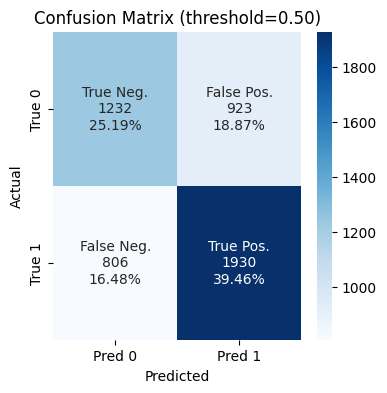

In [4]:
evaluator.plot_confusion_matrix(threshold=0.5)


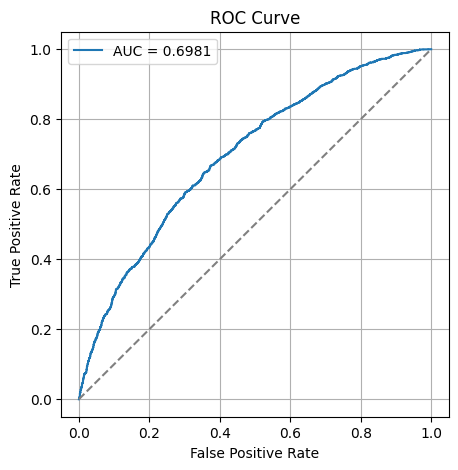

In [5]:
evaluator.plot_roc_curve()


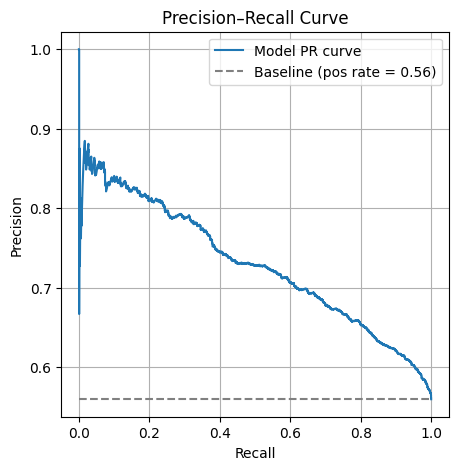

In [6]:
evaluator.plot_precision_recall_curve()


In [7]:
sweep_df = evaluator.threshold_sweep()
best_f1 = sweep_df.loc[sweep_df["f1"].idxmax()]
best_f1

threshold    0.330000
accuracy     0.626457
precision    0.607371
recall       0.939693
f1           0.737839
Name: 32, dtype: float64

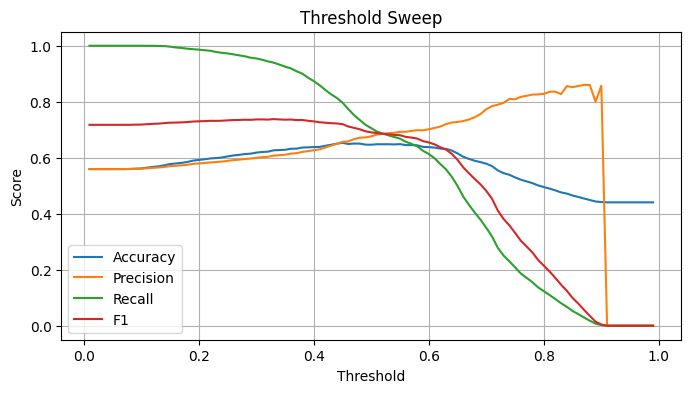

In [8]:
evaluator.plot_threshold_sweep()


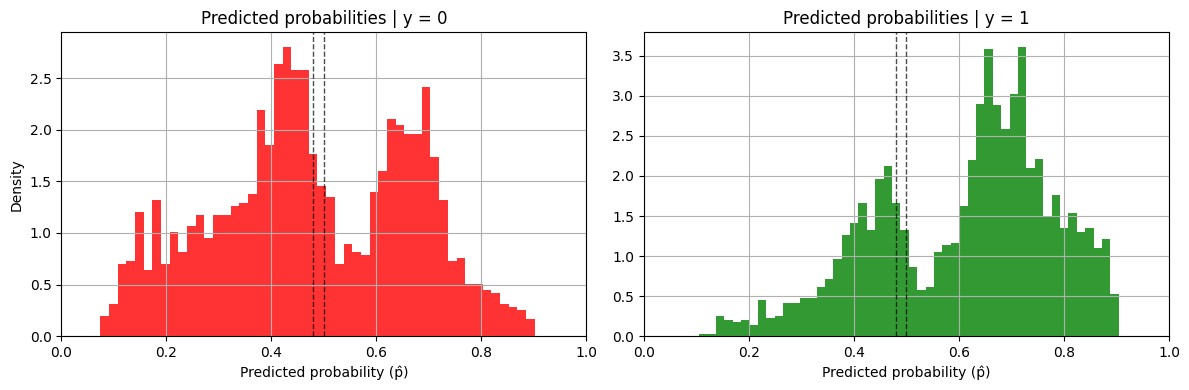

In [9]:
evaluator.summary_probability_stats()
evaluator.plot_probability_distribution(show_thresholds=[0.5, 0.48])

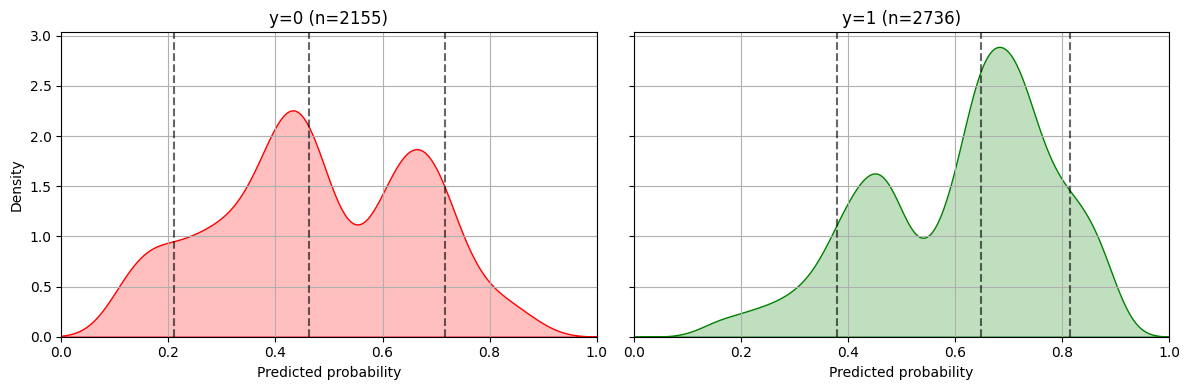

In [10]:
evaluator.plot_probability_kde()

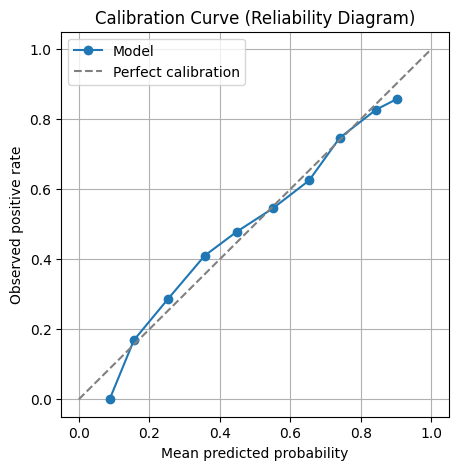

In [11]:
evaluator.plot_calibration_curve()

In [12]:
precision_scores = evaluator.compute_precision_scores()
precision_scores

{'10%': 0.5606557377049181,
 '50%': 0.6764808973010866,
 '90%': 0.8571428571428571}

In [13]:
print("ECE:", evaluator.expected_calibration_error())

ECE: 0.024388717780313568
